# IRK schemes with Gauss-Legendre nodes

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Definition-of-the-N-body-problem">
             Definition of the N-body problem</a></li>

<li><a href="#Initial-value-problem:-16-body-problem-(Solar-System)">
             Initial value problem: 16-body problem (Solar System)</a></li>

<li><a href="#Integration-with-IRK8">
             Integration with IRK8</a></li>

<li><a href="#Error-plots">
             Error plots</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRK
using LinearAlgebra
using Plots

  likely near /home/joseba/.julia/packages/IJulia/fXyGm/src/kernel.jl:52


<a href="#top">Back to the top</a>

## Definition of the N-body problem

In the following file, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODEs!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
v_1 & \cdots & v_N\\
q_1 & \cdots & q_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}



The ODE system of the N-body problem, with ficticious time $\tau$, related to the original time $t$ through the differential equation

$$
\frac{d}{d\tau} u = s(u)
$$

is:
\begin{equation*}
\begin{split}
\frac{d}{d\tau} q_i &= s(u)\, v_i, \\
\frac{d}{dt} v_i &= s(u)\, G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i)
\end{split}
\end{equation*}

where 

\begin{equation*}
s(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
- G \sum_{1\leq i < j \leq N} \frac{m_i+m_j}{\|q_i-q_j\|^3}.
\end{equation*}

This system of ODEs can be writen in compact form as

\begin{equation*}
\frac{d u}{d\tau} = F(t, u, Gm) := s(u)\, f(t,u,Gm).
\end{equation*}

<a href="#top">Back to the top</a>

## Initial value problem: 16-body problem (Solar System)

We consider $N=16$ bodies of solar system: the Sun, Mercury, Venus, the Earth, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto
the Moon, Ceres, Pallas, Vesta, Iris, Bamberga.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [2]:
include("InitialNBody16.jl")
u0, Gm =InitialNBody16()
N = length(Gm)
size(u0)

(2, 3, 16)

<a href="#top">Back to the top</a>


## Integration with IRK8 (Fixed-step)

Just to check that the output of the function NbodyODE has the expected type:

In [3]:
include("Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
size(du0)

(2, 3, 16)

Set up of the problem and integrate with symplectic integrator IRK8 (with no time reparametrization)

In [4]:
t0 = 0.
T = 350. # Final time
dt = 7.0 # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

In [5]:
(sol0,iter0,steps0)=@time(solve(prob,IRK8(),dt=dt,saveat=dt,adaptive=false,myoutputs=true));
(length(sol0.t))

  5.279743 seconds (17.99 M allocations: 1.290 GiB, 6.46% gc time)


51

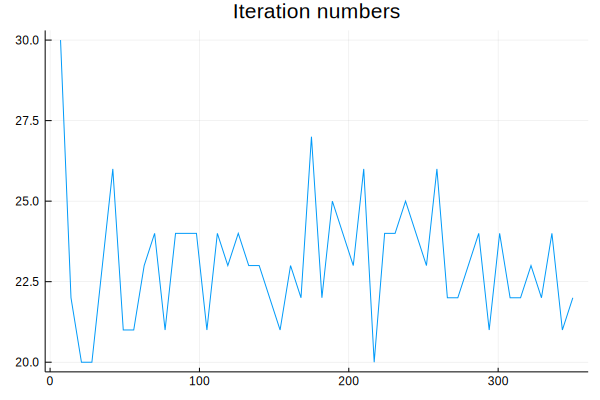

In [6]:
plot(sol0.t[2:end],iter0[2:end], title="Iteration numbers", legend=false)

## Integration with IRK8 (Adaptative-step)

In [19]:
dt = 7.

(sol1,iter1,steps1)=@time(solve(prob,IRK8(),dt=dt,saveat=dt, adaptative=true,
                                reltol=1e-16,abstol=1e-16,myoutputs=true));
length(sol1.t)

  1.159757 seconds (12.33 M allocations: 1.240 GiB, 13.71% gc time)


44

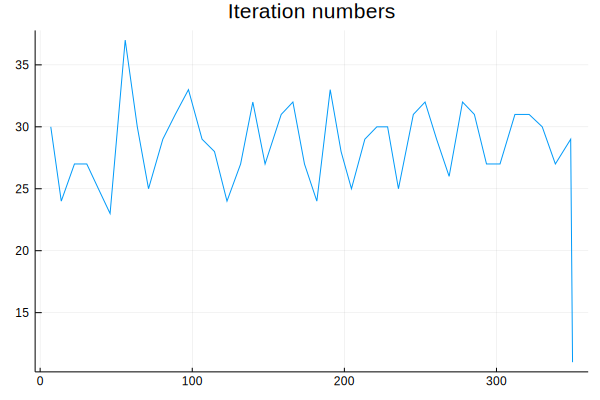

In [20]:
plot(sol1.t[2:end],iter1[2:end], title="Iteration numbers", legend=false)

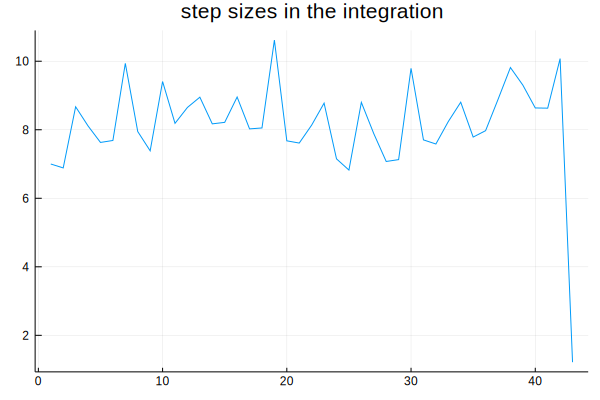

In [21]:
plot(steps1[2:end], title="step sizes in the integration", legend=false)

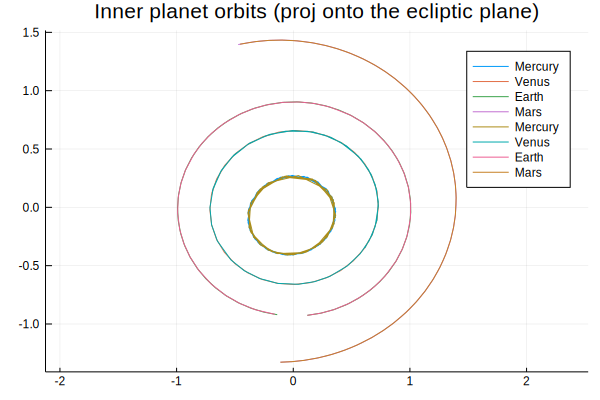

In [22]:
bodylist = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", 
            "Uranus", "Neptune", "Pluto", "Moon", "Ceres", "Pallas", "Vesta", 
             "Iris", "Bamberga"]
ulist0 = sol0.u
tlist0 = sol0.t


pl = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    

ulist1 = sol1.u[1:end-1]
tlist1 = sol1.t[1:end-1]

for j = 2:5
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  

plot(pl)

<a href="#top">Back to the top</a>

## Error in energy

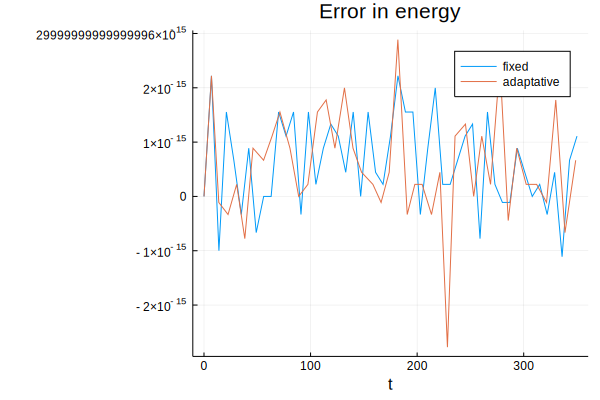

In [23]:
E0=NbodyEnergy(u0,Gm)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(sol0.u[j],Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end-1]
tlist1 = sol1.t[1:end-1]
EnergyErrors1=[NbodyEnergy(sol1.u[j],Gm)/E0-1 for j in 1:length(tlist1)]

plot(tlist[1:end],EnergyErrors, xlabel="t", title="Error in energy", label="fixed")
plot!(tlist1[1:end],EnergyErrors1, label="adaptative")